In [95]:
from landslide4sense.models import Unet
from landslide4sense.data import LandslideDataSet
from landslide4sense.data import LandslideDataSet
from landslide4sense.utils.tools import eval_image
from landslide4sense.models import Unet
from landslide4sense import EPSILON
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import omegaconf
import matplotlib.pyplot as plt
from torch.nn import Upsample, CrossEntropyLoss
import numpy as np
from tqdm import tqdm
import sys

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = omegaconf.OmegaConf.load("../conf/config.yaml")
cfg

{'data': {'dir': '${hydra:runtime.cwd}/data/', 'train_list': '${hydra:runtime.cwd}/data/train.txt', 'eval_lists_paths': ['${hydra:runtime.cwd}/data/train.txt'], 'eval_names': ['train'], 'test_list': '${hydra:runtime.cwd}/data/valid.txt', 'input_size': [128, 128], 'augmentation': {'module': 'landslide4sense.data.augmentations', 'name': 'transforms'}}, 'model': {'restore_from': None, 'module': 'segmentation_models_pytorch', 'name': 'UnetPlusPlus', 'args': {'in_channels': 14, 'classes': 2}}, 'optimizer': {'restore_from': None, 'module': 'torch.optim', 'name': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0.0005}}, 'loss': {'module': 'segmentation_models_pytorch.losses', 'name': 'DiceLoss', 'args': {'ignore_index': 255, 'mode': 'multiclass'}}, 'train': {'start_epoch': 0, 'steps_per_epoch': 125, 'batch_size': 128, 'num_workers': 2, 'num_steps': 10000, 'num_steps_stop': 10000, 'gpu_id': 0, 'snapshot_dir': '/content/drive/MyDrive/data_science_projects/landslide4sense-2022/models/', 'seed': 42

In [97]:
model_path = "/content/drive/MyDrive/data_science_projects/landslide4sense-2022/models/split_data_aug/epoch_7_val_f1=73.21207127753885.pth"
model_state_dict = torch.load(
    model_path,
    map_location=torch.device('cpu')
)
model = Unet(n_classes=2)
model.load_state_dict(model_state_dict)
interp = torch.nn.Upsample(size=(128, 128), mode="bilinear")

In [98]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_split_val.txt",
    max_iters=1,
    set="labeled",
)

In [99]:
train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [108]:
model.eval()
all_preds = []
all_labels = []

for i, batch in tqdm(
    enumerate(train_loader),
    desc=f"Evaluating on train...",
    total=len(train_loader),
):
    image, label, _, name = batch
    label = label.squeeze().numpy().astype(np.uint8)
    image = image.float().to(device)

    with torch.no_grad():
        pred = model(image)

    pred = interp(F.softmax(pred, dim=1)).half().detach()
    all_preds.append(pred)
    all_labels.append(label)

Evaluating on train...:   0%|          | 0/301 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Evaluating on train...: 100%|██████████| 301/301 [02:19<00:00,  2.16it/s]


In [109]:
preds = torch.cat(all_preds).numpy()
labels = np.array(all_labels)
labels.shape

(301, 128, 128)

In [111]:
def evaluate(y_pred, y_true):
    TP, FP, TN, FN, n_valid_sample = eval_image(
        y_pred.astype(np.uint8).squeeze().reshape(-1) , 
        y_true.astype(np.uint8).squeeze().reshape(-1), 
        2
    )

    OA = np.sum(TP[1]) * 1.0 / n_valid_sample
    P = np.squeeze((TP[1] * 1.0) / (TP[1] + FP[1] + EPSILON))
    R = np.squeeze((TP[1] * 1.0) / (TP[1] + FN[1] + EPSILON))
    F1 = (2.0 * P * R) / (P + R + EPSILON)
    return OA, P, R, F1

In [135]:

num_classes = 2
num_thresholds = 150

def initialize_arrays(num: int, size: int):
    arrays = []
    for _ in range(num):
        arrays.append(np.zeros((size, 1)))
    return arrays

thrs, f1s, ps, rs, oas = initialize_arrays(5, num_thresholds)

for i, thr in tqdm(enumerate(np.linspace(0, 1, num_thresholds)), total=num_thresholds):
    y_pred = (preds[:, 1, :, :] > thr)
    OA, P, R, F1 = evaluate(y_pred, labels)
    thrs[i] = thr
    oas[i] = OA
    ps[i] = P
    rs[i] = R
    f1s[i] = F1

100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


In [141]:
thrs[f1s.argmax()]

array([0.40268456])

In [144]:
f1s.max()

0.7395928171551389

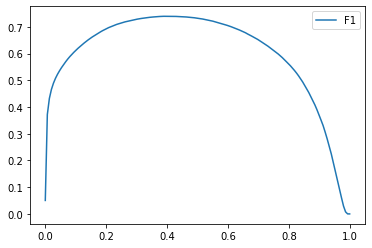

In [138]:
plt.plot(thrs, f1s, label="F1")
plt.plot(thrs, ps, label="Precision")
plt.plot(thrs, rs, label="Recall")
plt.legend()